# 	B1. Анализ и корректировка изображений

In [69]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

from PIL import Image
import cv2
import albumentations as A

import matplotlib.pyplot as plt

import librosa

import zipfile
import joblib
import os
import json

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Импорт данных

https://www.kaggle.com/datasets/rrighart/jarlids?select=p113.JPG

In [4]:
annots = pd.read_csv('data/jarlids_annots.csv')
annots.head(3)

,Unnamed: 0,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,0,p1.JPG,167996,{},12,0,"{""name"":""rect"",""x"":70,""y"":46,""width"":120,""heig...","{""type"":""intact""}"
1,1,p1.JPG,167996,{},12,1,"{""name"":""rect"",""x"":195,""y"":60,""width"":118,""hei...","{""type"":""intact""}"
2,2,p1.JPG,167996,{},12,2,"{""name"":""rect"",""x"":318,""y"":25,""width"":144,""hei...","{""type"":""damaged""}"


In [5]:
folder_data = os.listdir('data/')
photos = {}
for file in folder_data:
    if file.split('.')[1] == 'JPG':
        img = Image.open(f'data/{file}')
        photos[file] = img

### Построены гистограммы распределения пикселей по яркости и цветовым компонентам, сделана коррекция гистограммы

Гистограммы строим для первых 3 фотографий, чтобы не засорять вывод.

In [6]:
def plot_hist(img, img_new, number):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    img_array = np.array(img)
    colors = ('r', 'g', 'b')
    
    for i, color in enumerate(colors):
        ax1.hist(img_array[..., i].ravel(), color=color, label=color)
    ax1.set_title('До коррекции')

    for i, color in enumerate(colors):
        ax2.hist(np.array(img_new)[..., i].ravel(), color=color, label=color)
    ax2.set_title('После коррекции')
    
    plt.legend()
    plt.show()


def equalize_hist(img):
    img_array = np.array(img)

    new_img = np.zeros(img_array.shape)
    for i in range(3):
        new_img[..., i] = cv2.equalizeHist(img_array[..., i])
    return new_img

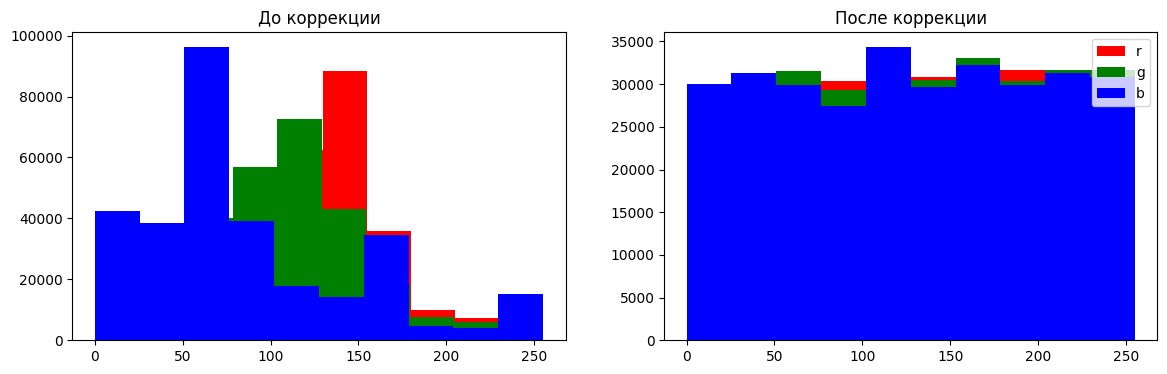

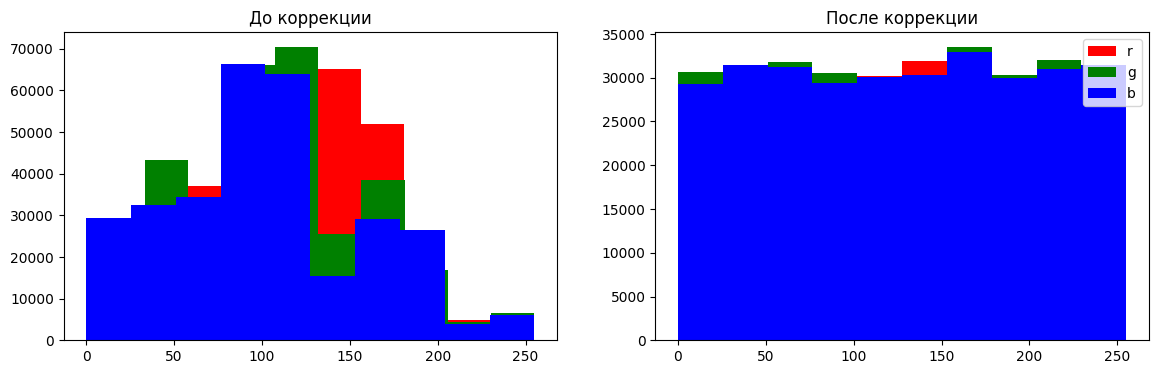

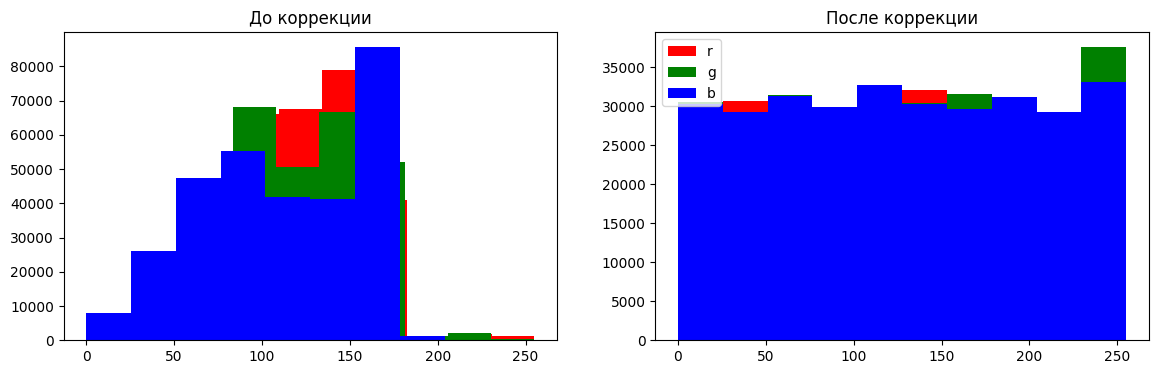

In [7]:
for i, (key, img) in enumerate(photos.items()):
    if i < 3:
        new_img = equalize_hist(img)
        plot_hist(img, new_img, i)
        photos[key] = new_img
    else:
        new_img = equalize_hist(img)
        photos[key] = new_img

### 	Проведена фильтрация изображений (выделение нужных областей (описывающих и показывающих дефекты) и удаление ненужных

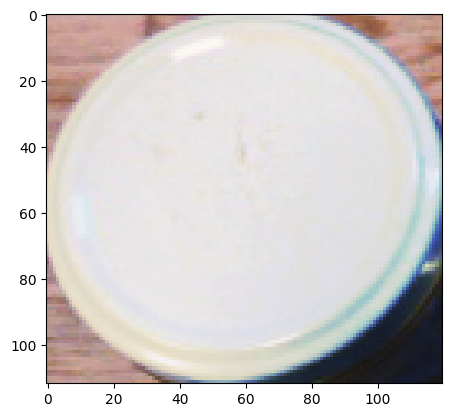

In [8]:
cr_photos = {}

for key, img in photos.items():
    img_copy = img.copy()  # Создаем копию, чтобы не изменять оригинал
    defect = json.loads(annots[annots['filename'] == key].iloc[0].region_shape_attributes)
    pt1 = (defect['x'], defect['y'])
    pt2 = (defect['x'] + defect['width'], defect['y'] + defect['height'])
    
    cropped_image = img_copy[defect['y']:defect['y'] + defect['height'], defect['x']:defect['x'] + defect['width']]

    if key == 'p1.JPG':
        plt.imshow(cropped_image / 255)
        plt.show()
        
    cr_photos[key] = cropped_image
    

### Проведено сглаживание изображений

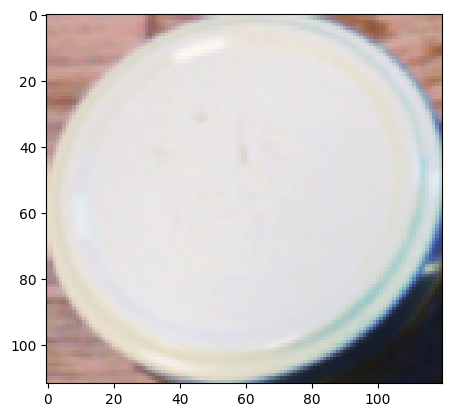

In [9]:
for key, img in cr_photos.items():
    blur_photo = cv2.blur(img, (2, 2))
    cr_photos[key] = blur_photo
    if key == 'p1.JPG':
        plt.imshow(blur_photo / 255)
        plt.show()
    

### Разработан и реализован алгоритм проверки качества снимков
Алгоритм проверки качества снимков включает 3 критерия проверки качества:
1. Резкость
2. Яркость
3. Контраст

In [10]:
def check_photo(img):
    img_cv2 = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Резкость
    sharpness = cv2.Laplacian(img_cv2, cv2.CV_64F).var()
    
    # Яркость
    brightness = img_cv2.mean()

    # Контраст
    contrast = np.std(img_cv2)
    
    print(f'Резкость: {sharpness:.2f}, Яркость: {brightness:.2f}, Контраст: {contrast:.2f}')
    
    if sharpness < 50:
        print('Изображение имеет проблемы с резкостью')
        return False
        
    elif 50 > brightness> 200:
        print('Изображение имеет проблемы с яркостью')
        return False

    elif contrast < 20:
        print('Изображение имеет проблемы с контрастом')
        return False
    else:
        return True

### Подготовлены и сохранены выборки с качественными и некачественными снимками

In [11]:
correct_photo = {}
incorrect_photo = {}

for key, img in cr_photos.items():
    if check_photo(img):
        correct_photo[key] = img
    else:
        incorrect_photo[key] = img

Резкость: 103.37, Яркость: 202.62, Контраст: 50.35
Резкость: 610.49, Яркость: 150.80, Контраст: 71.62
Резкость: 821.95, Яркость: 78.41, Контраст: 69.19
Резкость: 211.45, Яркость: 219.79, Контраст: 46.48
Резкость: 843.24, Яркость: 163.84, Контраст: 72.45
Резкость: 64.64, Яркость: 103.41, Контраст: 36.10
Резкость: 651.83, Яркость: 139.12, Контраст: 66.31
Резкость: 539.59, Яркость: 105.65, Контраст: 58.50
Резкость: 62.17, Яркость: 149.29, Контраст: 37.06
Резкость: 114.23, Яркость: 143.18, Контраст: 35.07
Резкость: 580.12, Яркость: 121.35, Контраст: 62.25
Резкость: 212.24, Яркость: 163.95, Контраст: 40.26
Резкость: 806.94, Яркость: 104.87, Контраст: 86.60
Резкость: 181.73, Яркость: 145.80, Контраст: 38.20
Резкость: 770.74, Яркость: 152.33, Контраст: 70.98
Резкость: 804.51, Яркость: 144.29, Контраст: 64.59
Резкость: 850.08, Яркость: 152.23, Контраст: 64.92
Резкость: 958.53, Яркость: 110.24, Контраст: 57.14
Резкость: 91.56, Яркость: 171.99, Контраст: 40.88
Резкость: 152.19, Яркость: 187.87, 

# B2. Анализ акустических данных	

### Импорт аудиоданных

https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs

In [12]:
audio_files = os.listdir('audio')
audio_def = {}
audio_no = {}

for file in audio_files:
    data, sr = librosa.load(f'audio/{file}')
    if 'cat' in file:
        audio_no[file] = data
    if 'dog' in file:
        audio_def[file] = data

audio_def[file]

array([-0.00047819, -0.0013533 , -0.00318004, ...,  0.01298007,
        0.01123521,  0.00360056], dtype=float32)

### Проведено Фурье-преобразование каждого акустического сигнала (с дефектом и без)

Звук можно перевести из временной области в частотную область с помощью быстрого преобразования Фурье таким образом, что после этого мы получим спектр сигнала. В librosa для этих целей есть функция librosa.stft()

In [13]:
# Без дефекта
furie_dict_no = {}
for key, audio in audio_no.items():
    furie_dict_no[key] = librosa.stft(y=audio)

# С дефектом
furie_dict_yes = {}
for key, audio in audio_def.items():
    furie_dict_yes[key] = librosa.stft(y=audio)

### 	Проведен частотно-временной анализ каждого сигнала (с дефектом и без)

Анализ для аудио с дефектом 1, максимальная частота: 64.53-5.11j
Анализ для аудио с дефектом 2, максимальная частота: 120.91+51.12j
Анализ для аудио с дефектом 3, максимальная частота: 229.73-105.30j
Анализ для аудио без дефекта 1, максимальная частота: 65.34+12.81j
Анализ для аудио без дефекта 2, максимальная частота: 171.18-32.60j
Анализ для аудио без дефекта 3, максимальная частота: 347.56-80.95j


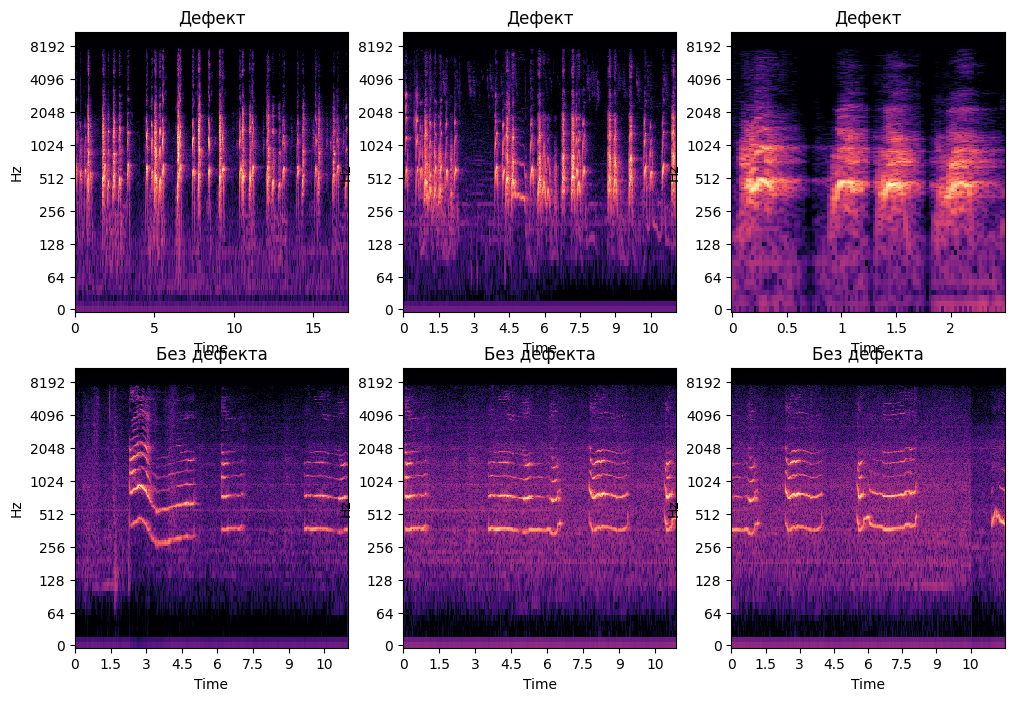

In [14]:
figure, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

list_data = list(furie_dict_yes.values())
librosa.display.specshow(librosa.amplitude_to_db(list_data[0], ref=np.max), ax=axs[0], y_axis='log', x_axis='time')
axs[0].set_title('Дефект')
print(f'Анализ для аудио с дефектом 1, максимальная частота: {list_data[0].max():.2f}')

librosa.display.specshow(librosa.amplitude_to_db(list_data[1], ref=np.max), ax=axs[1], y_axis='log', x_axis='time',)
axs[1].set_title('Дефект') 
print(f'Анализ для аудио с дефектом 2, максимальная частота: {list_data[1].max():.2f}')

librosa.display.specshow(librosa.amplitude_to_db(list_data[2], ref=np.max), ax=axs[2], y_axis='log', x_axis='time',)
axs[2].set_title('Дефект') 
print(f'Анализ для аудио с дефектом 3, максимальная частота: {list_data[2].max():.2f}')

list_data = list(furie_dict_no.values())
librosa.display.specshow(librosa.amplitude_to_db(list_data[3], ref=np.max), ax=axs[3], y_axis='log', x_axis='time',)
axs[3].set_title('Без дефекта')
print(f'Анализ для аудио без дефекта 1, максимальная частота: {list_data[0].max():.2f}')

librosa.display.specshow(librosa.amplitude_to_db(list_data[4], ref=np.max), ax=axs[4], y_axis='log', x_axis='time',)
axs[4].set_title('Без дефекта')
print(f'Анализ для аудио без дефекта 2, максимальная частота: {list_data[1].max():.2f}')

librosa.display.specshow(librosa.amplitude_to_db(list_data[5], ref=np.max), ax=axs[5], y_axis='log', x_axis='time',)
axs[5].set_title('Без дефекта');
print(f'Анализ для аудио без дефекта 3, максимальная частота: {list_data[2].max():.2f}')

### Выявлены характеристики сигнала, позволяющие определить наличие дефектов

В аудиофайлах с дефектом, более отрывистые частоты, тогда как в аудио без дефектов более равномерные сигналы, которые редко заходят за порог в 2048 Гц.

### Определены информативные частоты для определения наличия дефектов

При наличии дефекта частоты выходят из порога [256, 2048] Гц.

# 	B3. Сегментация изображений

### 	Произведен поиск контуров дефектов на всех изображениях

In [15]:
def get_contours(img):
    grey_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)

    # Применяем PCA для декомпозиции
    pca = PCA(n_components=50)  # Количество компонент для анализа
    pca_result = pca.fit_transform(grey_img)

    # Реконструкция изображения из главных компонент
    pca_reconstructed = pca.inverse_transform(pca_result)
    pca_reconstructed_img = pca_reconstructed.reshape(grey_img.shape)
    
    # Бинаризация
    ret, thresh = cv2.threshold(grey_img, 120, 200, 0)
    # Пороговое выделение контуров
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [16]:
contours = {}
for key, img in correct_photo.items():
    cont = get_contours(img)
    contours[key] = cont

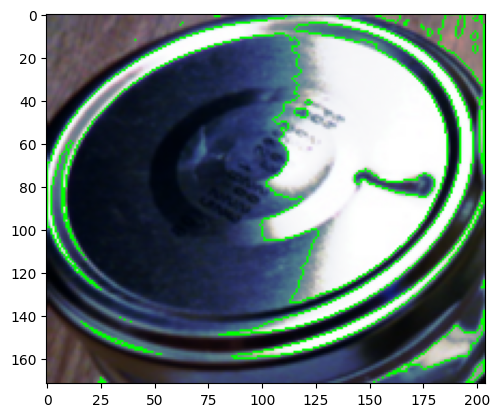

In [17]:
plt.imshow(cv2.drawContours(correct_photo['p11.JPG'].copy(), contours['p11.JPG'], -1, (0,255,0), 1) / 255)

Исходя из визуализации можно сделать вывод, что алгоритм хорошо отчерчивает дефект

# 	B4. Расширение набора данных с помощью методов аугментации

- Выполнены и визуализированы зеркальные отражения	
- Выполнены и визуализированы повороты	
- Выполнены и визуализированы приближения/отдаления (зумы)	
- Выполнена и визуализированы смена яркости	
- Выполнена и визуализированы смена контрастности	
- Используются и визуализируются обрезки (кропы)	
- Используются и визуализируются наклоны	
- Используются и визуализируются вращения

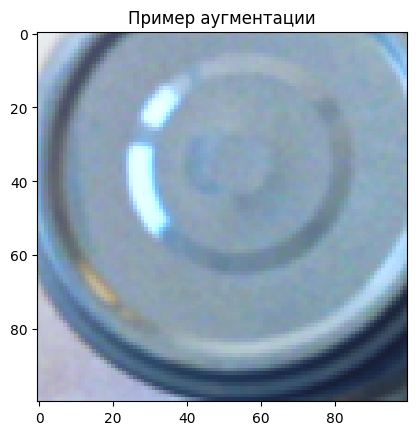

In [64]:
img_transforms = A.Compose([
    A.HorizontalFlip(), # зеркальные отражения	
    A.RandomRotate90(), # повороты/вращения
    A.RandomScale(), # приближения/отдаления (зумы)	
    A.RandomBrightnessContrast(), # смена яркости и контраста
    A.Affine(shear=(-15, 15)) , # наклоны
    A.RandomCrop(width=100, height=100), # обрезки (кропы)	
]
)

for key, image in correct_photo.items():
    # Сохраняем предобработанные фото
    image2save = Image.fromarray(image.astype('uint8'))
    image2save.save(f'preprocess_photo/{key.split(".")[0]}.jpg')
    # Создаем 5 аугментирванных фото
    for i in range(5):
        aug_image = img_transforms(image=(img))['image'].astype('uint8')
        aug_image = Image.fromarray(aug_image)
        aug_image.save(f'aug_photo/{key.split(".")[0]}_aug_{i}.jpg')
 
        

plt.imshow(img_transforms(image=(img / 255))['image'])
plt.title('Пример аугментации');

# B5. Формирование итогового набора расширенных и предобработанных данных

### Сформирован итоговый набор расширенных и предобработанных данных
Итоговый набор расширенных и предобработанных данных содержит разметку для всех сгенерированных изображений

### Итоговый набор данных изображений и разметок сохранен в архив с расширением .zip

In [70]:
# Сохраняем в json
joblib.dump(contours, 'contours.json')

['contours.json']

In [73]:
with zipfile.ZipFile("data.zip", "w") as zf:
    # Изображения
    for folder in ['aug_photo', 'preprocess_photo']:
        for image in os.listdir(folder):
             zf.write(f"{folder}/{image}")

    # Разметка
    zf.write("contours.json")

# B6. Подготовка итоговой версии технического задания (ТЗ)

Техническое задание скорректировано с учетом встречи с экспертом по неразрушающему контролю (дефектоскопистом) – учтены требования по ВИК (визуально-измерительный контроль). Техническое задание скорректировано с учетом встречи с экспертом по программным решениям для бизнеса – учтены требования к API для интеграции с программным продуктом